In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm

import librosa
import librosa.display
import IPython.display as ipd
from sklearn.utils import resample
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

<div style="text-align: center; font-size: 30px; color: red;">Audio Data Loading & Basic Inspection</div>

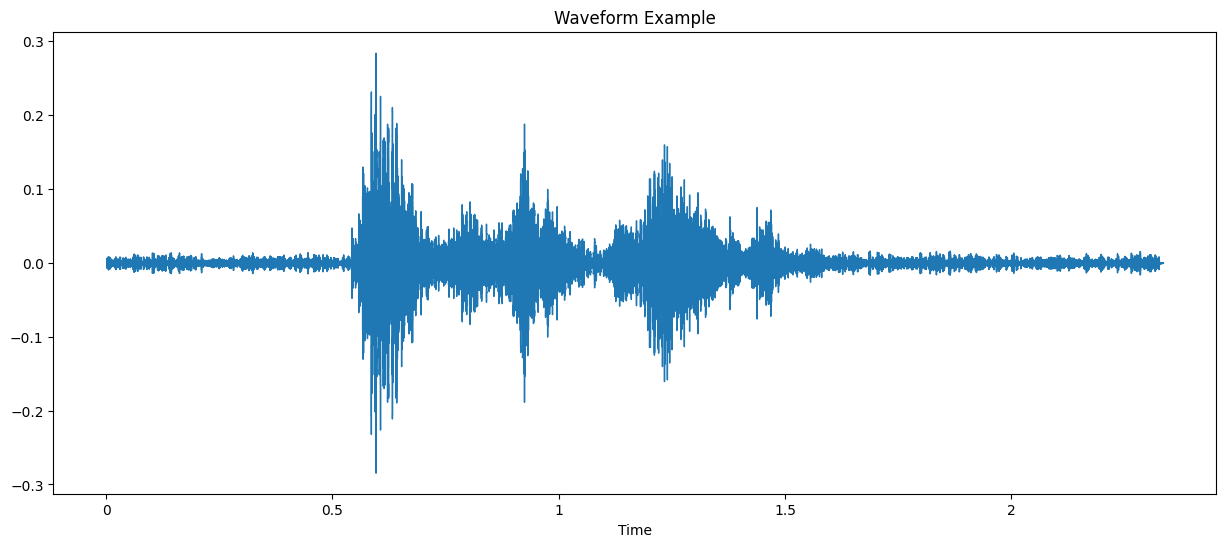

In [2]:
# Load sample
data, sr = librosa.load("../data/1001_DFA_DIS_XX.wav", sr = None, mono=False)

# Plot waveform
plt.figure(figsize=(15, 6))
librosa.display.waveshow(y=data, x_axis='time', sr=sr)
plt.title("Waveform Example")
plt.show()

In [3]:
# Play Audio
ipd.Audio("../data/1001_DFA_DIS_XX.wav")

In [4]:
# Check number of channels
if data.ndim == 1:
    print("File is a Mono Channel")
elif data.ndim == 2:
    print("File is Stereo Channel")

File is a Mono Channel


<div style="text-align: center; font-size: 30px; color: red;">Exploratory Data Analysis</div>

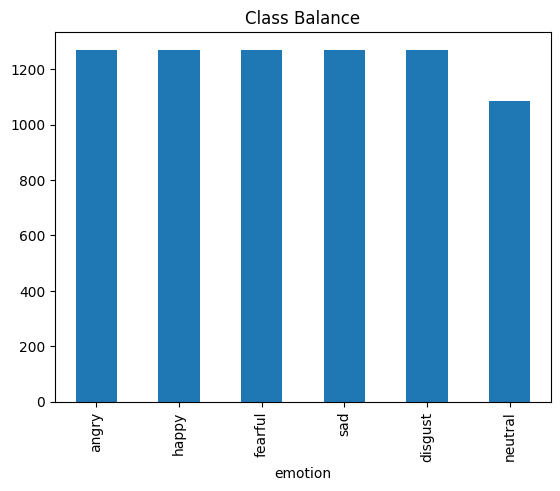

In [5]:
# Check for Class Imbalance
emotion_map = {
        'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fearful',
        'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'
}
emotions = []
for dirpath, dirnames, filenames in os.walk("../data"):
    for file in filenames:
        emotion = emotion_map[file.split('_')[-2]]
        emotions.append(emotion)
df = pd.DataFrame(emotions)
df.columns = ["emotion"]
df["emotion"].value_counts().plot(kind='bar')
plt.title("Class Balance");

**NOTE**
- All classes balanced except neutral. Consider resampling?

In [6]:
# Sample Audio for each emotion
ipd.Audio("../data/1001_DFA_ANG_XX.wav") # Anger

In [7]:
ipd.Audio("../data/1001_DFA_FEA_XX.wav") # Fear

In [8]:
ipd.Audio("../data/1001_IEO_DIS_HI.wav") # Disgust

In [9]:
ipd.Audio("../data/1001_DFA_HAP_XX.wav") # Happy

In [10]:
ipd.Audio("../data/1001_IEO_SAD_MD.wav") # Sad

**NOTE**
- Audio length is **NOT CONSISTENT**

In [11]:
def fix_length(y, target_len = sr*3):
    # Target is 3 seconds
    if len(y) > target_len:
        y_trunc = y[:target_len]
        return y_trunc
    else:
        y_pad = np.pad(y, (0, target_len - len(y)))
        return y_pad

<div style="font-size: 25px; color: green;">Waveform and Spectrogram Samples</div>

In [12]:
# Instantiate Samples
fearful = "../data/1001_DFA_FEA_XX.wav"
happy = "../data/1001_IEO_HAP_HI.wav"
sad = "../data/1001_DFA_SAD_XX.wav"
angry = "../data/1001_DFA_ANG_XX.wav"
neutral = "../data/1001_DFA_NEU_XX.wav"
disgust = "../data/1001_DFA_DIS_XX.wav"
# Put in list for easy iteration
samples_list = [fearful, happy, sad, angry, neutral, disgust]
samples_list

['../data/1001_DFA_FEA_XX.wav',
 '../data/1001_IEO_HAP_HI.wav',
 '../data/1001_DFA_SAD_XX.wav',
 '../data/1001_DFA_ANG_XX.wav',
 '../data/1001_DFA_NEU_XX.wav',
 '../data/1001_DFA_DIS_XX.wav']

In [13]:
def visualize_audio(path):
    # Get the emotion
    file = os.path.basename(path)
    emotion = emotion_map[os.path.basename(path).split("_")[-2]]
    
    # Plot waveform
    y, sr = librosa.load(path, sr=None)
    plt.figure(figsize=(15, 6))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"{emotion.title()} Waveform")
    plt.show()
    
    # Plot spectrogram
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(np.abs(X))
    plt.figure(figsize=(15, 6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.title(f"{emotion.title()} Spectrogram")
    plt.show()

    # Plot mel-spectrogram
    # Initiate Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    # Scale to db
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    # Mel Spectrogram Plot
    plt.figure(figsize=(15, 6))
    librosa.display.specshow(data=mel_db,
                             sr=sr,
                             hop_length=512,
                             x_axis="time",
                             y_axis="mel",
                             cmap="viridis")
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{emotion.title()} Mel Spectrogram");

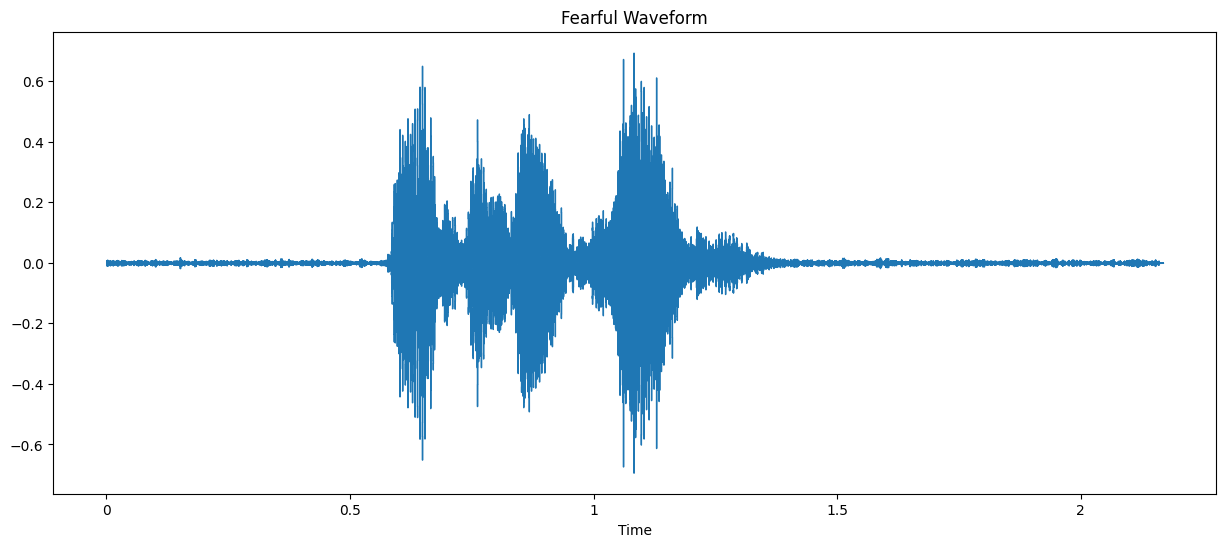

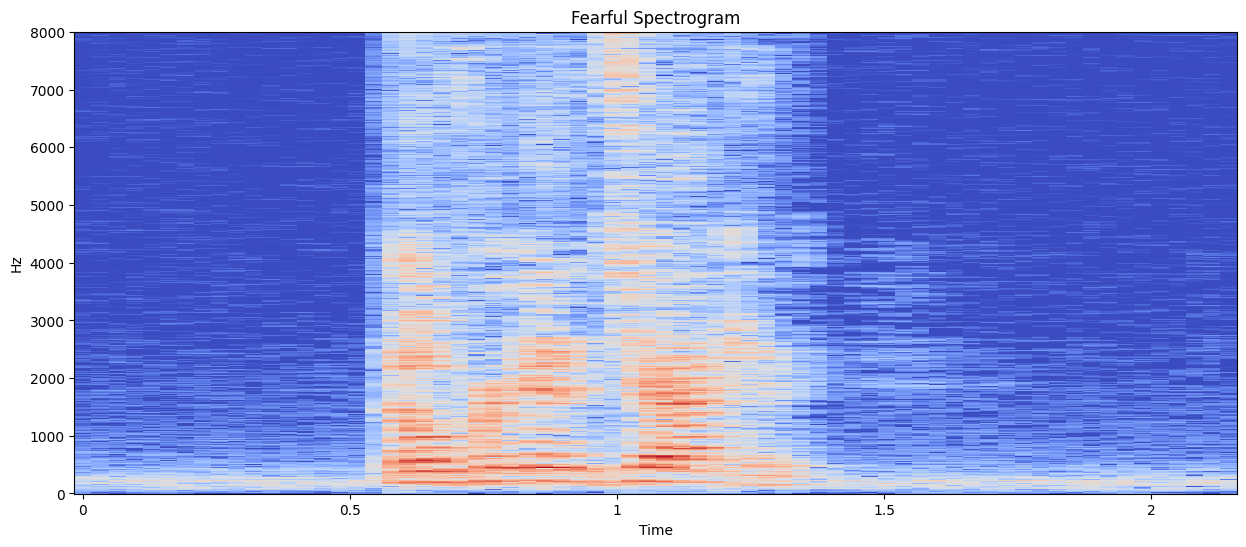

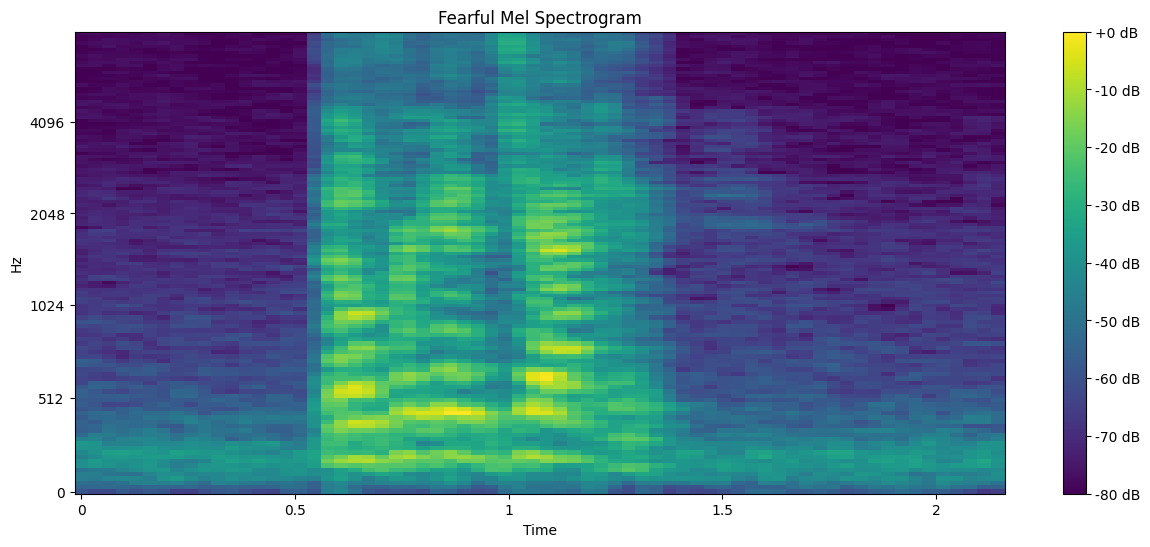

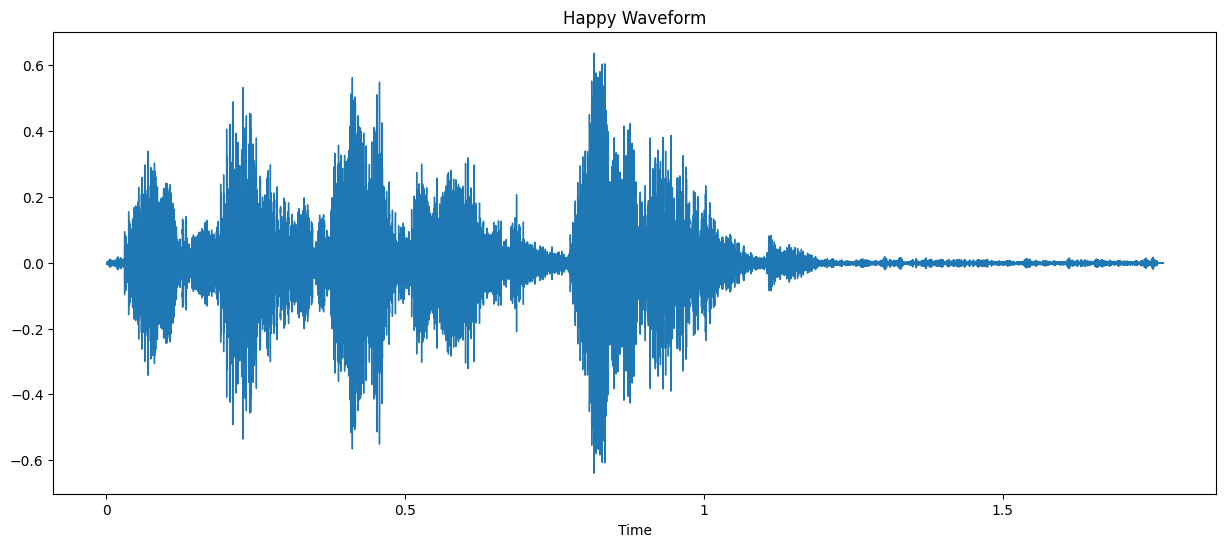

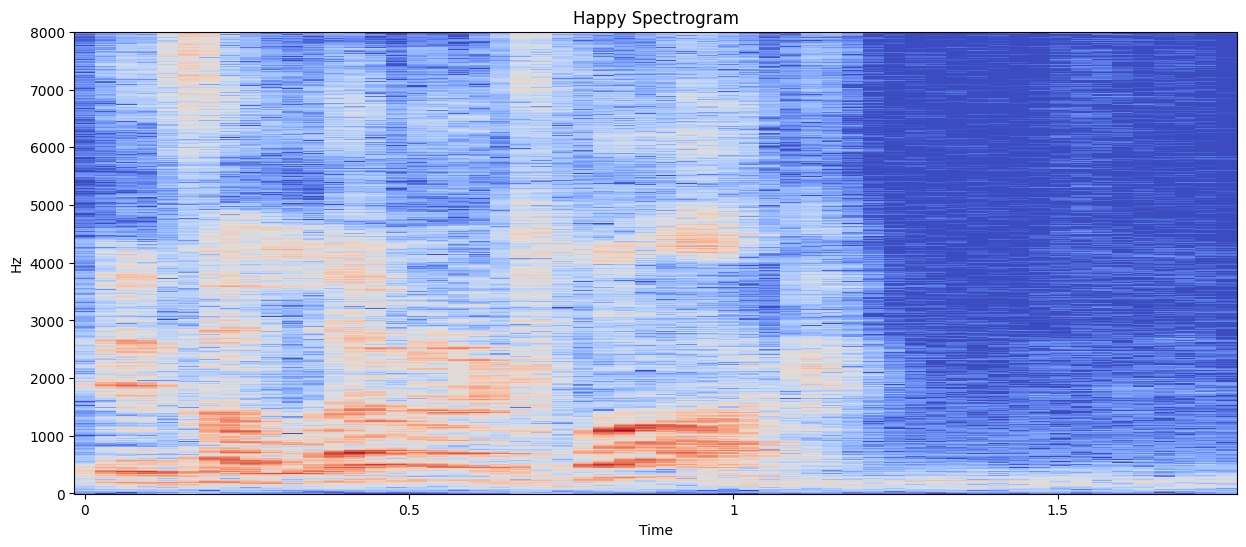

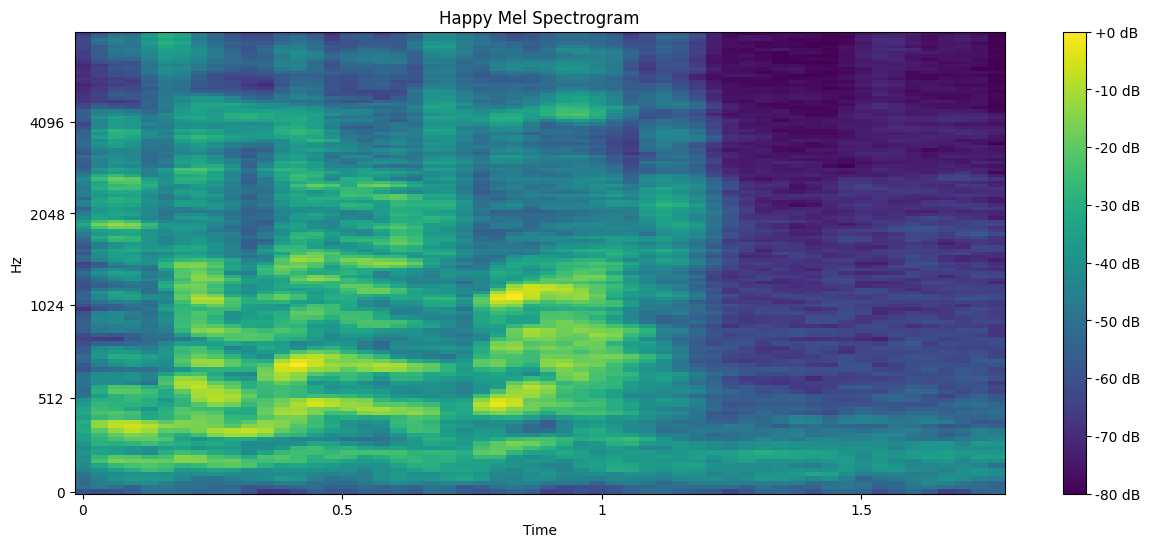

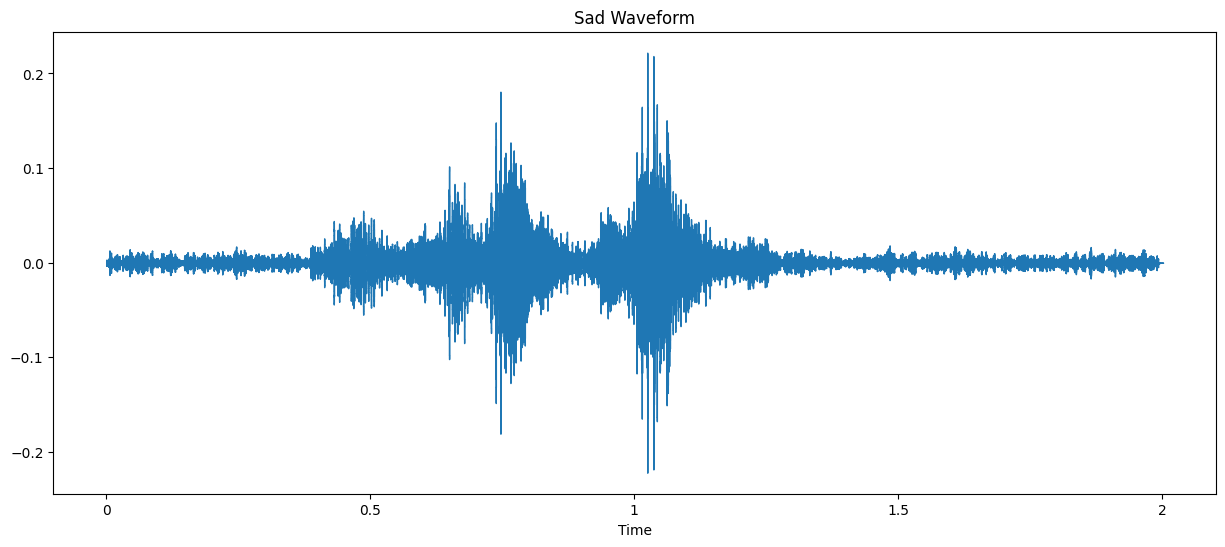

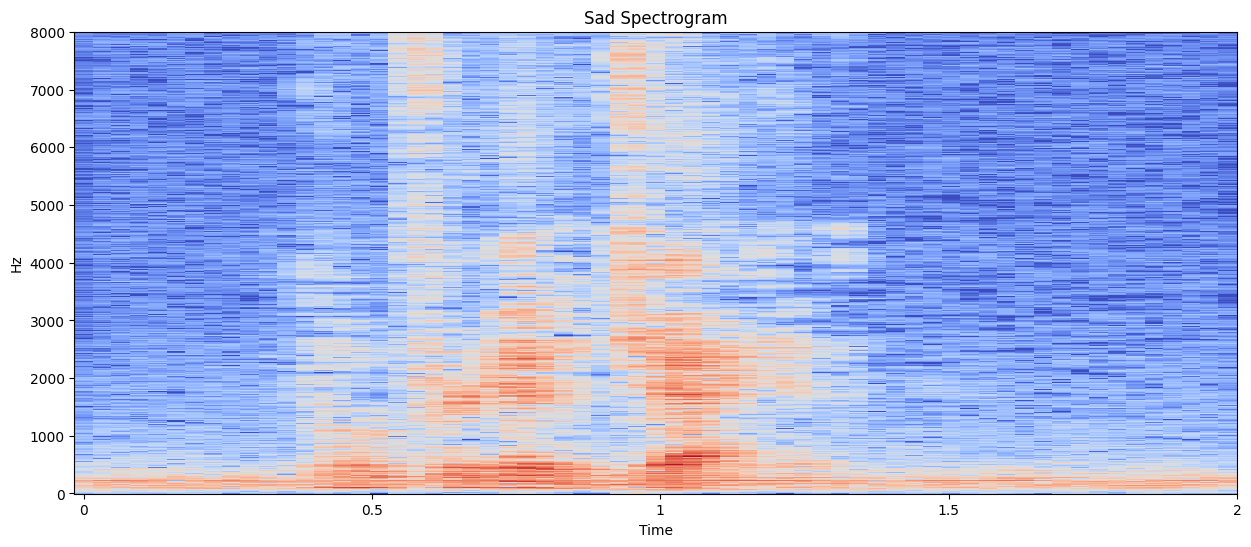

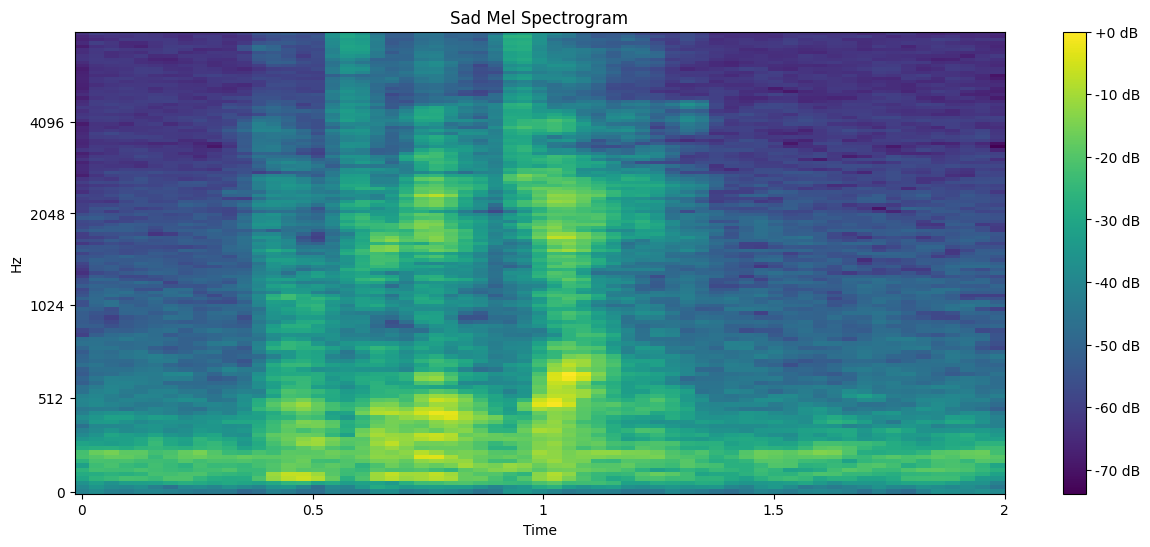

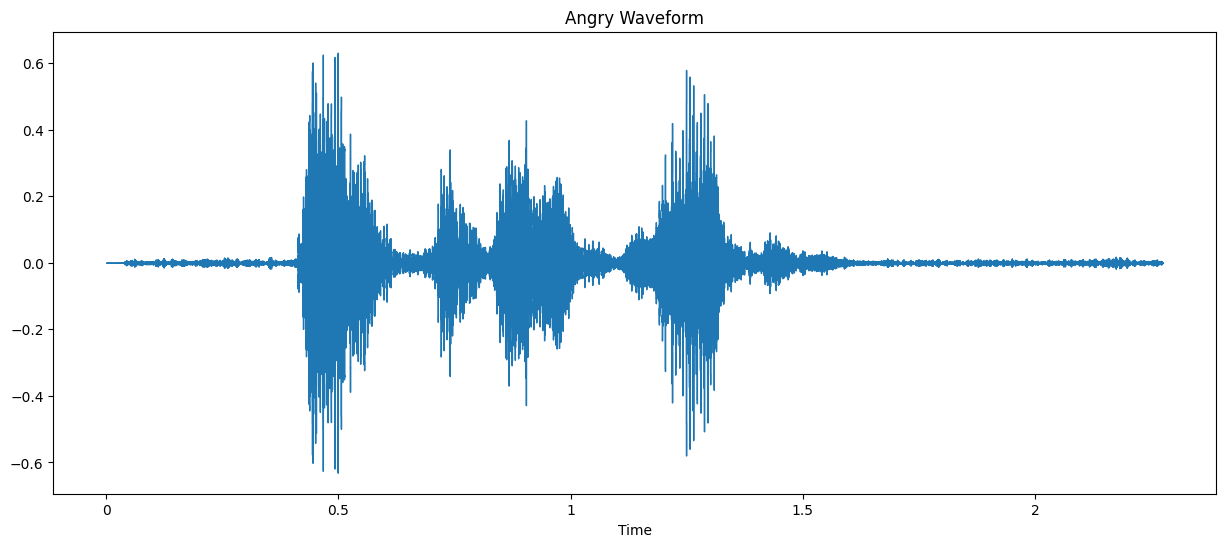

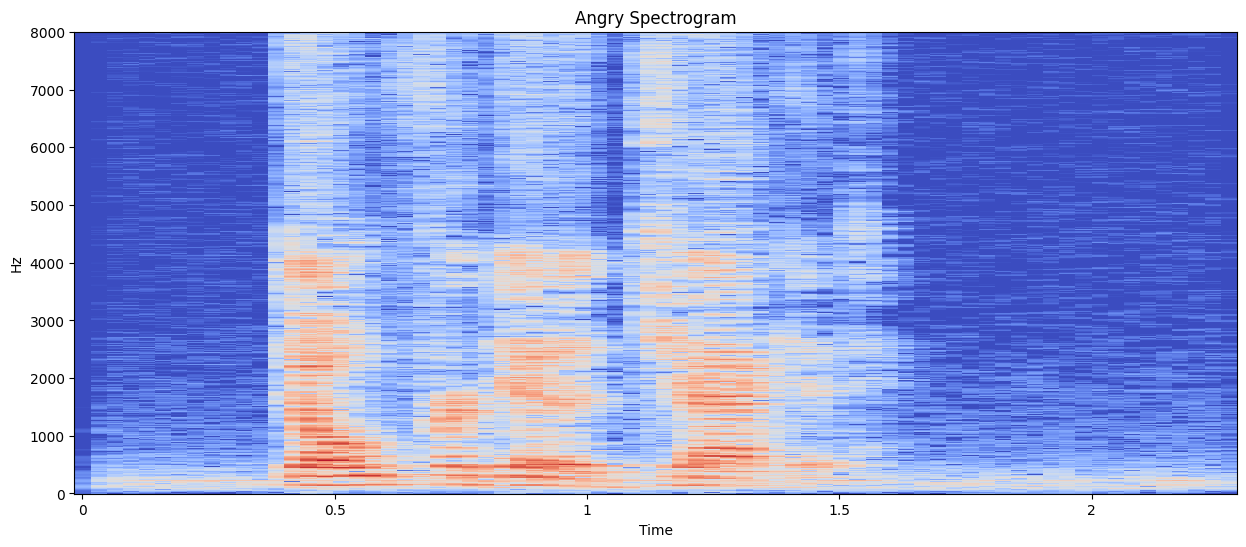

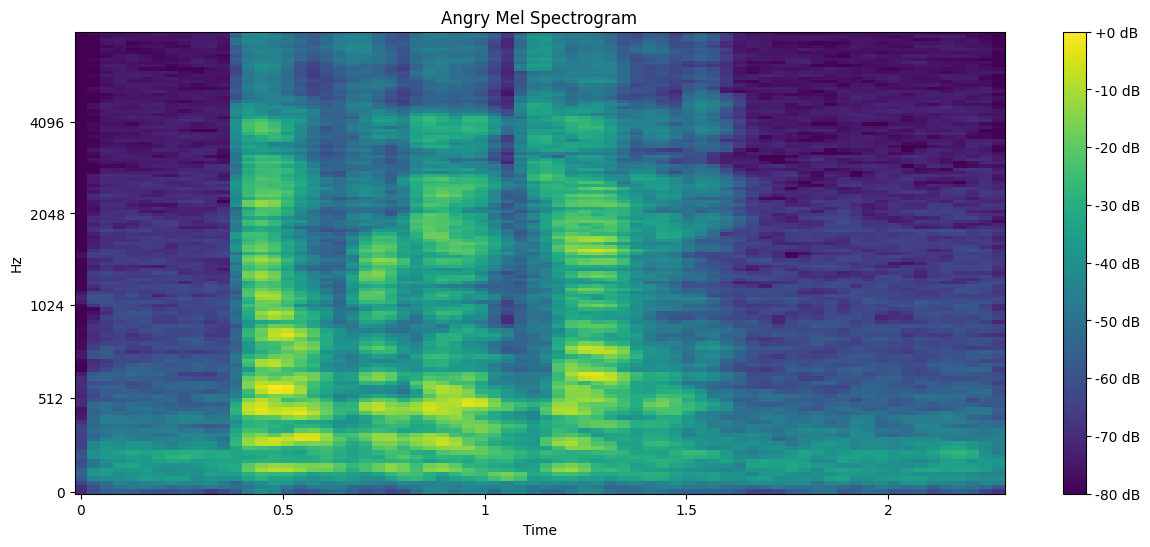

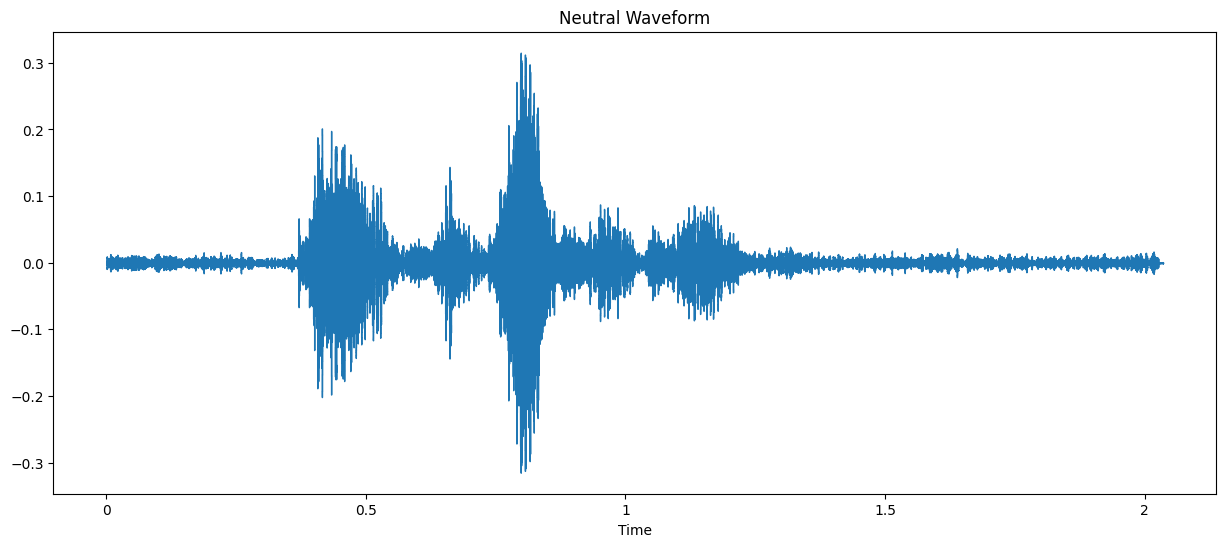

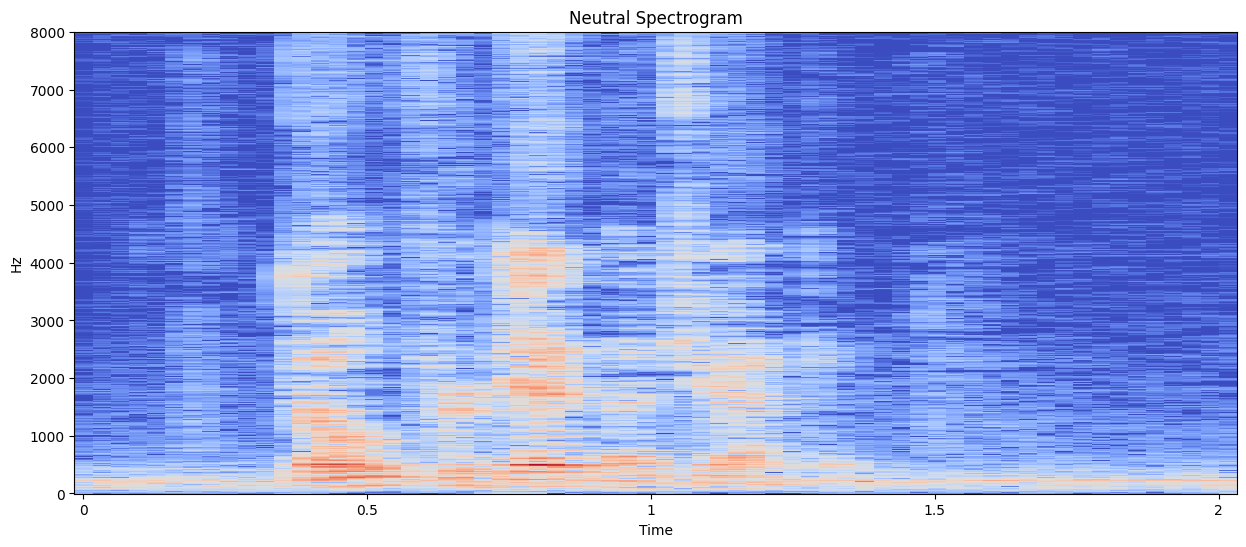

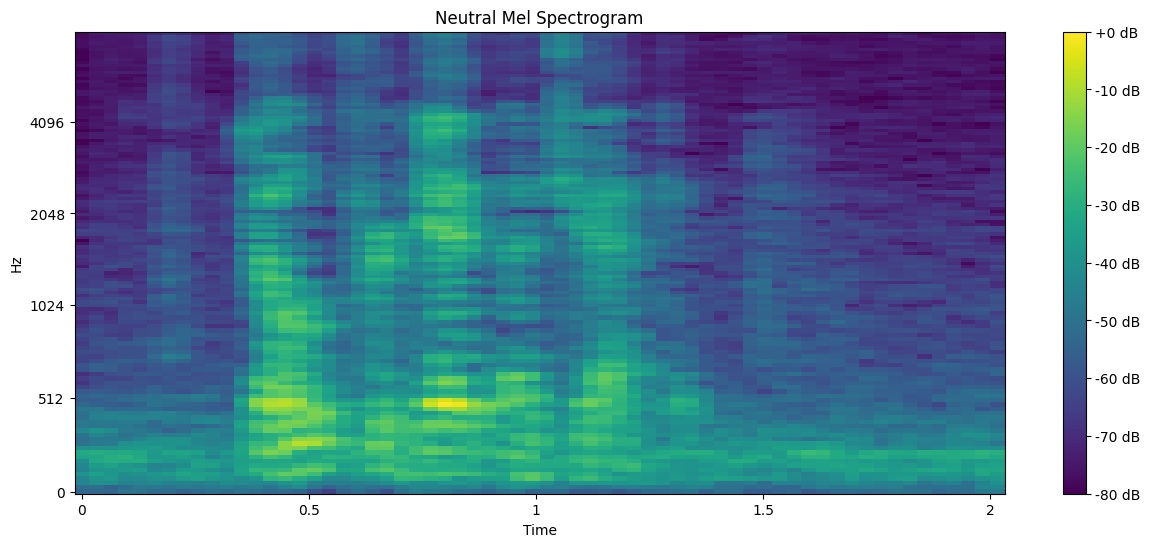

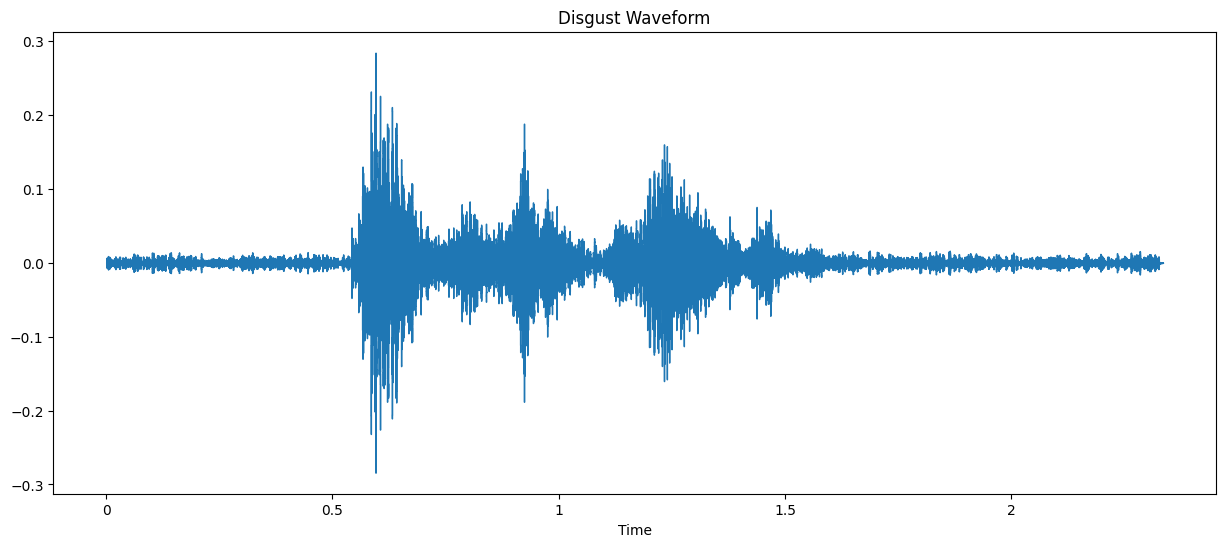

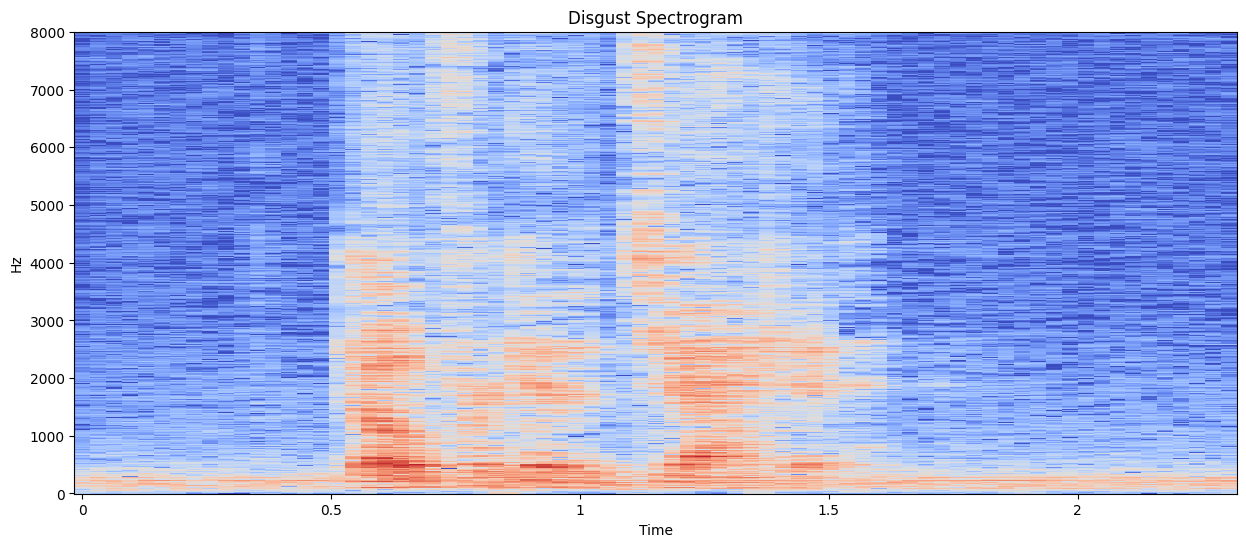

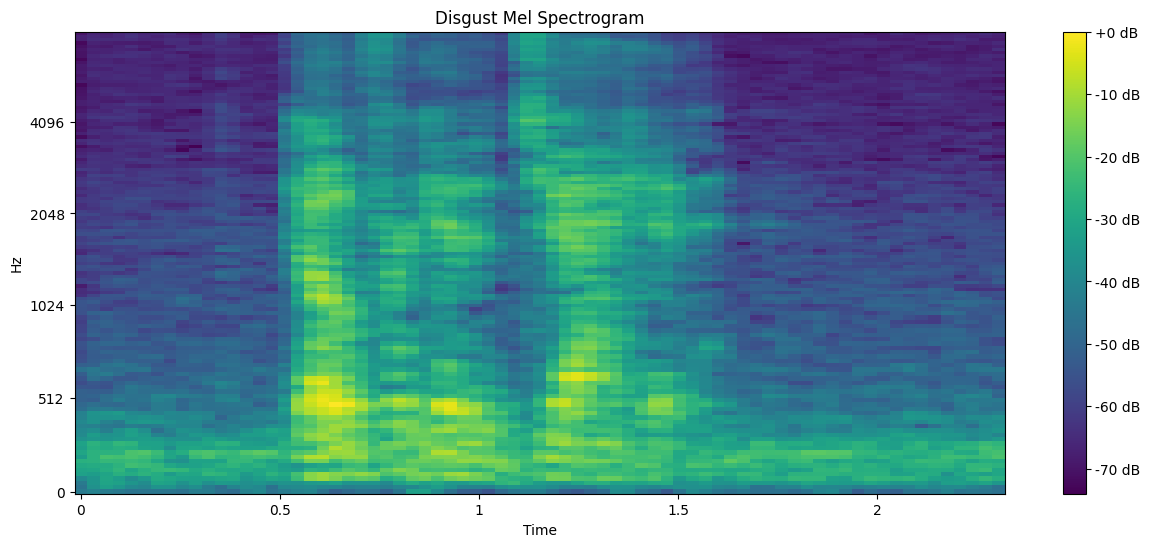

In [14]:
for sample in samples_list:
    visualize_audio(sample)

In [15]:
# Check fix length function
y, sr = librosa.load(neutral, sr=None)
print(f'Initial length: {len(y)}')
fixed_len = fix_length(y)
print(f'Fixed length: {len(fixed_len)}')

Initial length: 32566
Fixed length: 48000


<div style="font-size: 25px; color: green;">Resampling</div>

**NOTE**
- There's a slight imbalance. I'll have to oversample neutral class to bring everything level

In [16]:
# Create a reference list for your data. Item e.g, (path, emotion)
data = []
for dirpath, dirnames, filenames in os.walk("../data"):
    for file in filenames:
        path = os.path.join(dirpath, file)
        speaker = file.split('_')[0] # Need to identify speaker since dataset is speaker-independent
        emotion = emotion_map[file.split('_')[-2]]
        data.append((path, speaker, emotion))
data[:5]

[('../data/1044_MTI_ANG_XX.wav', '1044', 'angry'),
 ('../data/1071_IEO_ANG_LO.wav', '1071', 'angry'),
 ('../data/1025_MTI_ANG_XX.wav', '1025', 'angry'),
 ('../data/1001_ITH_NEU_XX.wav', '1001', 'neutral'),
 ('../data/1052_IOM_HAP_XX.wav', '1052', 'happy')]

In [17]:
# Put data into a dataframe
data_df = pd.DataFrame(data)
data_df.columns = ["path","speaker", "emotion"]

data_df.head()

,path,speaker,emotion
0,../data/1044_MTI_ANG_XX.wav,1044,angry
1,../data/1071_IEO_ANG_LO.wav,1071,angry
2,../data/1025_MTI_ANG_XX.wav,1025,angry
3,../data/1001_ITH_NEU_XX.wav,1001,neutral
4,../data/1052_IOM_HAP_XX.wav,1052,happy


In [18]:
# Split into majority and minority classes for resampling
majority_df = data_df[data_df["emotion"]!="neutral"]
minority_df = data_df[data_df["emotion"]=="neutral"]

In [19]:
# Perform oversampling
neutral_upsampled = resample(
    minority_df,
    replace = True,
    n_samples = 1271,
    random_state = 42
)

In [20]:
# Combine back to one df
data_df = pd.concat([majority_df, neutral_upsampled])
data_df["emotion"].value_counts()

emotion
angry      1271
happy      1271
sad        1271
fearful    1271
disgust    1271
neutral    1271
Name: count, dtype: int64

In [21]:
data_df.head()

,path,speaker,emotion
0,../data/1044_MTI_ANG_XX.wav,1044,angry
1,../data/1071_IEO_ANG_LO.wav,1071,angry
2,../data/1025_MTI_ANG_XX.wav,1025,angry
4,../data/1052_IOM_HAP_XX.wav,1052,happy
5,../data/1066_ITH_SAD_XX.wav,1066,sad


**NOTE**
- This dataset **IS NOT** inherently speaker dependent!

<div style="font-size: 25px; color: green;">Splitting</div>

**NOTE**
- Since the dataset is speaker-independent, I'll have to split it manually into 5 folds by the speakers

In [22]:
# Define folds
folds = {
    1: list(range(1037, 1055)),
    2: list(range(1001, 1019)),
    3: list(range(1073, 1092)),
    4: list(range(1055, 1073)),
    5: list(range(1019, 1037))
}

# Define path to files
path = "../data/"

# Fold files variable
fold_files = defaultdict(list)

# The iteration
for filename in os.listdir(path):
    # Get speaker id
    speaker_id = int(filename.split('_')[0])
    # Match id to its fold and append filename
    for fold_num, speakers in folds.items():
        if speaker_id in speakers:
            fold_files[fold_num].append(filename)
            break

In [23]:
# Assign files to sets
train_files = []
val_files = []
test_files = []
# Iterate and add files to respective list
for fold_num, paths in fold_files.items():
    if fold_num == 1 or fold_num == 2 or fold_num == 3:
        for path in paths:
            train_files.append(path)
    elif fold_num == 4:
        for path in paths:
            val_files.append(path)
    else:
        for path in paths:
            test_files.append(path)

In [24]:
print(f"Number of training files: {len(train_files)}")
print(f'Number of validation files: {len(val_files)}')
print(f'Number of test files: {len(test_files)}')

Number of training files: 4496
Number of validation files: 1476
Number of test files: 1470


<div style="font-size: 25px; color: green;">Audio Preprocessing</div>

In [25]:
# Fix length and normalize audio function
def preprocess(path):
    # Load audio
    y, sr = librosa.load(path, sr=None)
    # Fix length
    fixed_len = fix_length(y)
    # Peak normalization
    peak = np.max(np.abs(fixed_len))
    target_peak = 0.99
    normalized_audio = y/peak * target_peak * 0.95
    return normalized_audio

<div style="font-size: 25px; color: green;">Feature Extraction</div>

In [26]:
# Extract features function
def extract_features(path):
    result = np.array([])
    # Load audio
    y, sr = librosa.load(path, sr=None)
    # Extract spectrogram
    stft = np.abs(librosa.stft(y))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft))
    # Extract mel spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128).T, axis=0)
    result = np.hstack((result, mel))
    # Extract Mel-Frequency Cepstral Frequencies(MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    mfcc_delta = np.mean(librosa.feature.delta(mfcc.T), axis=0)
    mfcc_delta2 = np.mean(librosa.feature.delta(mfcc.T, order=2), axis=0)
    result = np.hstack((result, mfcc_mean, mfcc_delta, mfcc_delta2))
    # Extract spectral features
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
    result = np.hstack((result, contrast, bandwidth, centroid, rolloff))
    # Extract chroma features
    cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr).T, axis=0)
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    cqt = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr).T, axis=0)
    result = np.hstack((result, cens, chroma_stft, cqt))
    # Extract Root Mean Square Energy
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
    result = np.hstack((result, rms))
    # Extract zero crossing rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)
    result = np.hstack((result, zcr))
    # Return features array
    return result